# Lung 3D segmentation with MONAI

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     |████████████████████████████████| 939 kB 14.8 MB/s 
     |████████████████████████████████| 251 kB 98.4 MB/s 


In [2]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    EnsureType,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

In [3]:
from google.colab import drive
import os

drive.mount('/content/drive', force_remount=True)

root_dir = "/content/drive/My Drive/"
project_folder = "FYP/MONAI_Lung/"
data_loc = "FYP/MONAI_Lung/Data/Task06_Lung/"

data_dir = root_dir + data_loc


def create_and_set_working_directory(project_folder):
  if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + ' did not exist but was created.')

  os.chdir(root_dir + project_folder)
  print('\nYour working directory was changed to ' + root_dir + project_folder)

create_and_set_working_directory(project_folder)

Mounted at /content/drive

Your working directory was changed to /content/drive/My Drive/FYP/MONAI_Lung/


# Lung Dataset loading

In [4]:
train_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

In [5]:
set_determinism(seed=0)

# Training and validation transforms

In [6]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        EnsureTyped(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        EnsureTyped(keys=["image", "label"]),
    ]
)

# Check the transforms in the Dataloader

image shape: torch.Size([512, 386, 450]), label shape: torch.Size([512, 386, 450])


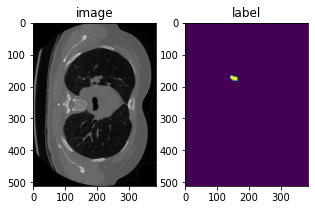

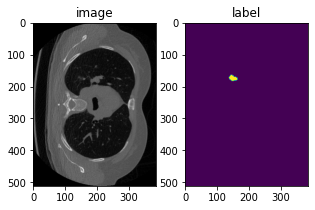

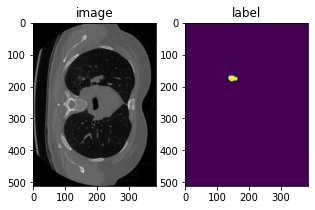

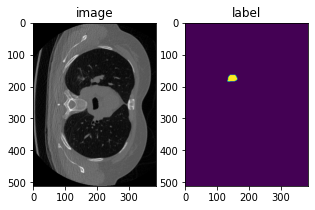

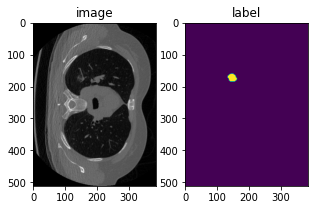

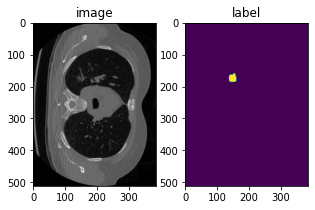

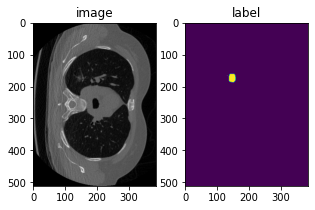

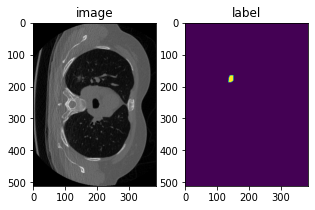

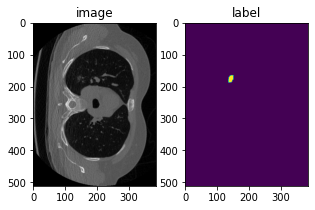

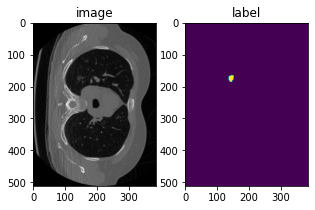

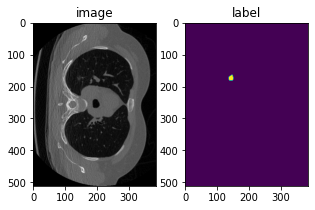

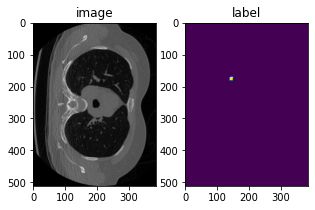

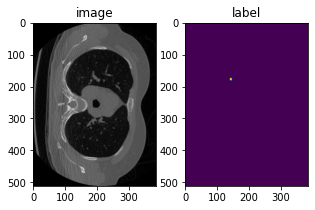

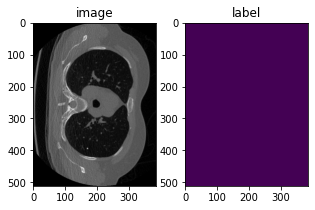

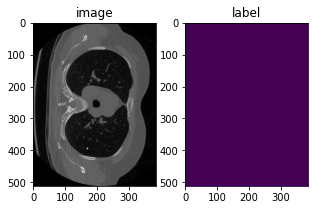

In [ ]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
for i in range(315,330):
  plt.figure(figsize=(5, 3))
  plt.subplot(1, 2, 1)
  plt.title("image")
  plt.imshow(image[:, :, i], cmap="gray")
  plt.subplot(1, 2, 2)
  plt.title("label")
  plt.imshow(label[:, :, i])
plt.show()

In [7]:
train_ds = CacheDataset(
    data=train_files, transform=train_transforms,
    cache_rate=1.0, num_workers=4)

train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)

val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|██████████| 9/9 [00:17<00:00,  2.00s/it]


# Create the model, with the loss and optimiser specified too

In [8]:
from typing import Optional, Sequence, Tuple, Union

import torch
import torch.nn as nn

from monai.networks.blocks.convolutions import Convolution, ResidualUnit
from monai.networks.layers.factories import Act, Norm
from monai.networks.layers.simplelayers import SkipConnection
from monai.utils import alias, deprecated_arg, export

class TestNet(nn.Module):
    
    def __init__(self):
        super(TestNet, self).__init__()

        channels = [32,64,128,192,256,384,512,768,1024,2048]
        self.down1 = Convolution(3, 1, channels[0], strides=2, kernel_size=3, act=Act.PRELU, norm=Norm.BATCH, dropout=0.0, bias=True)
        self.down2 = Convolution(3, channels[0], channels[1], strides=2, kernel_size=7, act=Act.PRELU, norm=Norm.BATCH, dropout=0.0, bias=True)
        self.down3 = Convolution(3, channels[1], channels[2], strides=2, kernel_size=5, act=Act.PRELU, norm=Norm.BATCH, dropout=0.0, bias=True)
        self.down4 = Convolution(3, channels[2], channels[3], strides=2, kernel_size=3, act=Act.PRELU, norm=Norm.BATCH, dropout=0.0, bias=True)
        self.down5 = Convolution(3, channels[3], channels[4], strides=2, kernel_size=3, act=Act.PRELU, norm=Norm.BATCH, dropout=0.0, bias=True)

        self.up5 = Convolution(3, channels[4], channels[3], strides=2, kernel_size=3, act=Act.PRELU, norm=Norm.BATCH, dropout=0.0, bias=True, conv_only=False, is_transposed=True)
        self.up4 = Convolution(3, channels[3], channels[2], strides=2, kernel_size=3, act=Act.PRELU, norm=Norm.BATCH, dropout=0.0, bias=True, conv_only=False, is_transposed=True)
        self.up3 = Convolution(3, channels[2], channels[1], strides=2, kernel_size=3, act=Act.PRELU, norm=Norm.BATCH, dropout=0.0, bias=True, conv_only=False, is_transposed=True)
        self.up2 = Convolution(3, channels[1], channels[0], strides=2, kernel_size=3, act=Act.PRELU, norm=Norm.BATCH, dropout=0.0, bias=True, conv_only=False, is_transposed=True)

        self.res5 = Convolution(3, 2*channels[3], channels[3], strides=1, kernel_size=3, act=Act.PRELU, norm=Norm.BATCH, dropout=0.0, bias=True, conv_only=False, is_transposed=True)
        self.res4 = Convolution(3, 2*channels[2], channels[2], strides=1, kernel_size=3, act=Act.PRELU, norm=Norm.BATCH, dropout=0.0, bias=True, conv_only=False, is_transposed=True)
        self.res3 = Convolution(3, 2*channels[1], channels[1], strides=1, kernel_size=3, act=Act.PRELU, norm=Norm.BATCH, dropout=0.0, bias=True, conv_only=False, is_transposed=True)
        self.res2 = Convolution(3, 2*channels[0], channels[0], strides=1, kernel_size=3, act=Act.PRELU, norm=Norm.BATCH, dropout=0.0, bias=True, conv_only=True, is_transposed=True)
        self.res1 = Convolution(3, channels[0], 2, strides=1, kernel_size=3, act=Act.PRELU, norm=Norm.BATCH, dropout=0.0, bias=True, conv_only=True, is_transposed=True)

        self.up1 = Convolution(3, channels[0], 2, strides=2, kernel_size=3, act=Act.PRELU, norm=Norm.BATCH, dropout=0.0, bias=True, conv_only=False, is_transposed=True)

        self.mcnn_4 = Convolution(3, channels[3], 8, strides=1, kernel_size=3, act=Act.PRELU, norm=Norm.BATCH, dropout=0.0, bias=True)
        self.mcnn_3 = Convolution(3, channels[2], 8, strides=1, kernel_size=3, act=Act.PRELU, norm=Norm.BATCH, dropout=0.0, bias=True)
        self.mcnn_2 = Convolution(3, channels[1], 8, strides=1, kernel_size=3, act=Act.PRELU, norm=Norm.BATCH, dropout=0.0, bias=True)
        self.mcnn_1 = Convolution(3, channels[0], 8, strides=1, kernel_size=3, act=Act.PRELU, norm=Norm.BATCH, dropout=0.0, bias=True)

        self.mcnn_general = Convolution(3, 8, 2, strides=1, kernel_size=3, act=Act.PRELU, norm=Norm.BATCH, dropout=0.0, bias=True)

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)

        u5 = self.up5(d5)
        skip5 = self.res5(torch.cat([u5,d4],dim=1))
        u4 = self.up4(skip5)
        skip4 = self.res4(torch.cat([u4,d3],dim=1))
        u3 = self.up3(skip4)
        skip3 = self.res3(torch.cat([u3,d2],dim=1))
        u2 = self.up2(skip3)
        skip2 = self.res2(torch.cat([u2,d1],dim=1))
        output = self.up1(skip2)

        mcnn_4 = self.mcnn_4(skip5)
        mcnn4 = self.mcnn_general(mcnn_4)

        mcnn_3 = self.mcnn_3(skip4)
        mcnn3 = self.mcnn_general(mcnn_3)

        mcnn_2 = self.mcnn_2(skip3)
        mcnn2 = self.mcnn_general(mcnn_2)

        mcnn_1 = self.mcnn_1(skip2)
        mcnn1 = self.mcnn_general(mcnn_1)

        return output, mcnn4, mcnn3, mcnn2, mcnn1

device = torch.device("cuda:0")

model = TestNet().to(device)

loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

# Define output resolution reduction function

In [9]:
import numpy as np
from skimage.measure import block_reduce
def make_block_reduce(input_layers, dim=(2,2,2,2), mode=np.max):
    stacked_layers = [block_reduce( image, dim, mode) for image in input_layers]
    return np.asarray(stacked_layers, dtype='float32')

In [10]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "MCNN_low_res_epoch_400.pth")))

<All keys matched successfully>

# Execute custom PyTorch MCNN training process


In [11]:
import warnings
warnings.filterwarnings("ignore")

In [12]:
max_epochs = 400
val_interval = 1
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
epoch_full_res_loss_values = []
epoch_res_1_loss_values = []
epoch_res_2_loss_values = []
epoch_res_3_loss_values = []
epoch_res_4_loss_values = []
metric_values = []
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=2)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    epoch_full_res_loss = 0
    epoch_res_1_loss = 0
    epoch_res_2_loss = 0
    epoch_res_3_loss = 0
    epoch_res_4_loss = 0

    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )

        labels1 = make_block_reduce(labels.cpu().detach().numpy(), dim = (2,2,2,2), mode=np.max)
        labels2 = make_block_reduce(labels1, dim = (2,2,2,2), mode=np.max)
        labels3 = make_block_reduce(labels2, dim = (2,2,2,2), mode=np.max)
        labels4 = make_block_reduce(labels3, dim = (2,2,2,2), mode=np.max)

        optimizer.zero_grad()
        outputs, mcnn4s, mcnn3s, mcnn2s, mcnn1s = model(inputs)
        
        loss_orig = loss_function(outputs, labels)
        loss1 = loss_function(mcnn1s, torch.from_numpy(labels1).to(device))
        loss2 = loss_function(mcnn2s, torch.from_numpy(labels2).to(device))
        loss3 = loss_function(mcnn3s, torch.from_numpy(labels3).to(device))
        loss4 = loss_function(mcnn4s, torch.from_numpy(labels4).to(device))
        loss = 0.6*loss_orig + 0.6*loss1 + 0.6*loss2 + 0.6*loss3 + 0.6*loss4

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_full_res_loss += loss_orig.item()
        epoch_res_1_loss += loss1.item()
        epoch_res_2_loss += loss2.item()
        epoch_res_3_loss += loss3.item()
        epoch_res_4_loss += loss4.item()

        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"total_loss: {loss.item():.4f}, "
            f"full res loss: {loss_orig.item():.4f}, "
            f"1/2 res loss: {loss1.item():.4f}, "
            f"1/4 res loss: {loss2.item():.4f}, "
            f"1/8 res loss: {loss3.item():.4f}, "
            f"1/16 res loss: {loss4.item():.4f}")
    epoch_loss /= step
    epoch_full_res_loss /= step
    epoch_res_1_loss /= step
    epoch_res_2_loss /= step
    epoch_res_3_loss /= step
    epoch_res_4_loss /= step

    epoch_loss_values.append(epoch_loss)
    epoch_full_res_loss_values.append(epoch_full_res_loss)
    epoch_res_1_loss_values.append(epoch_res_1_loss)
    epoch_res_2_loss_values.append(epoch_res_2_loss)
    epoch_res_3_loss_values.append(epoch_res_3_loss)
    epoch_res_4_loss_values.append(epoch_res_4_loss)

    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}, average full res loss: {epoch_full_res_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model)
                val_outputs = val_outputs[0]
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "400_med_best.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

Streaming output truncated to the last 5000 lines.
26/27, total_loss: 0.9298, full res loss: 0.4091, 1/2 res loss: 0.3032, 1/4 res loss: 0.2889, 1/8 res loss: 0.2775, 1/16 res loss: 0.2711
27/27, total_loss: 0.7531, full res loss: 0.3612, 1/2 res loss: 0.2403, 1/4 res loss: 0.2274, 1/8 res loss: 0.2173, 1/16 res loss: 0.2091
epoch 244 average loss: 0.9674, average full res loss: 0.4012
current epoch: 244 current mean dice: 0.4018
best mean dice: 0.4537 at epoch: 152
----------
epoch 245/400
1/27, total_loss: 0.8814, full res loss: 0.3667, 1/2 res loss: 0.2831, 1/4 res loss: 0.2794, 1/8 res loss: 0.2712, 1/16 res loss: 0.2688
2/27, total_loss: 0.7867, full res loss: 0.3852, 1/2 res loss: 0.2531, 1/4 res loss: 0.2393, 1/8 res loss: 0.2241, 1/16 res loss: 0.2094
3/27, total_loss: 1.0591, full res loss: 0.4251, 1/2 res loss: 0.3470, 1/4 res loss: 0.3399, 1/8 res loss: 0.3343, 1/16 res loss: 0.3190
4/27, total_loss: 0.9171, full res loss: 0.4050, 1/2 res loss: 0.2999, 1/4 res loss: 0.2882, 

In [13]:
torch.save(model.state_dict(), os.path.join(root_dir, "400_med_end.pth"))

In [14]:
import pandas as pd

dict = {'total loss': epoch_loss_values, 'full res': epoch_full_res_loss_values, '1/2 res': epoch_res_1_loss_values, 
        '1/4 res': epoch_res_2_loss_values, '1/8 res': epoch_res_3_loss_values, '1/16 res': epoch_res_4_loss_values}  
df = pd.DataFrame(dict) 
df.to_csv(root_dir+project_folder+"400_med_loss.csv") 

dict = {'dice metric': metric_values}
df = pd.DataFrame(dict) 
df.to_csv(root_dir+project_folder+"400_med_dice.csv") 

In [ ]:
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.0829 at epoch: 150


# Graph the Dice loss and Dice metric by epoch

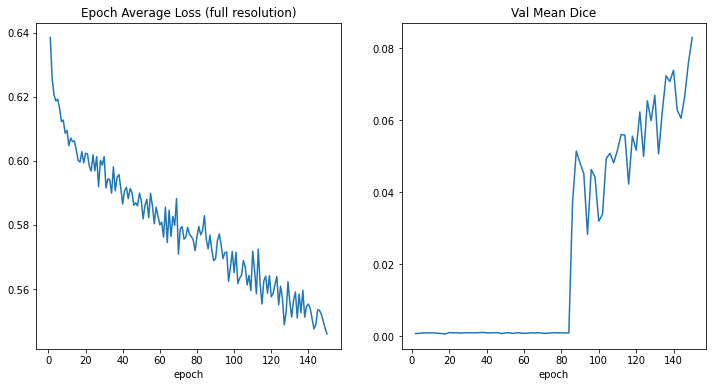

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss (full resolution)")
x = [i + 1 for i in range(len(epoch_full_res_loss_values))]
y = epoch_full_res_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

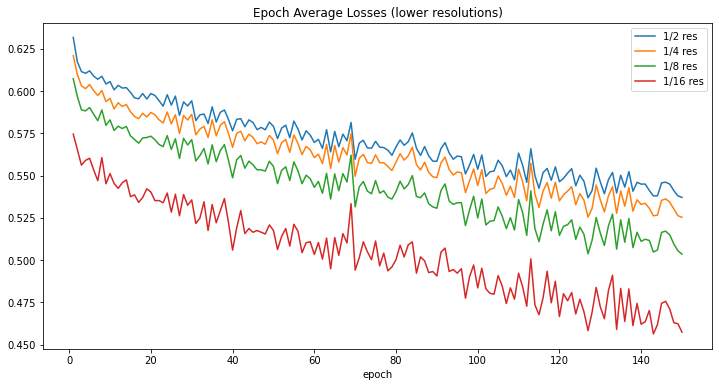

In [ ]:
plt.figure("train", (12, 6))
plt.title("Epoch Average Losses (lower resolutions)")
x1 = [i + 1 for i in range(len(epoch_res_1_loss_values))]
y = epoch_res_1_loss_values
plt.xlabel("epoch")
plt.plot(x1, y, label="1/2 res")
x2 = [i + 1 for i in range(len(epoch_res_2_loss_values))]
y = epoch_res_2_loss_values
plt.plot(x2, y, label="1/4 res")
x3 = [i + 1 for i in range(len(epoch_res_3_loss_values))]
y = epoch_res_3_loss_values
plt.plot(x3, y, label="1/8 res")
x4 = [i + 1 for i in range(len(epoch_res_4_loss_values))]
y = epoch_res_4_loss_values
plt.plot(x4, y, label="1/16 res")
plt.legend()
plt.show()

# Evaluate model outputs

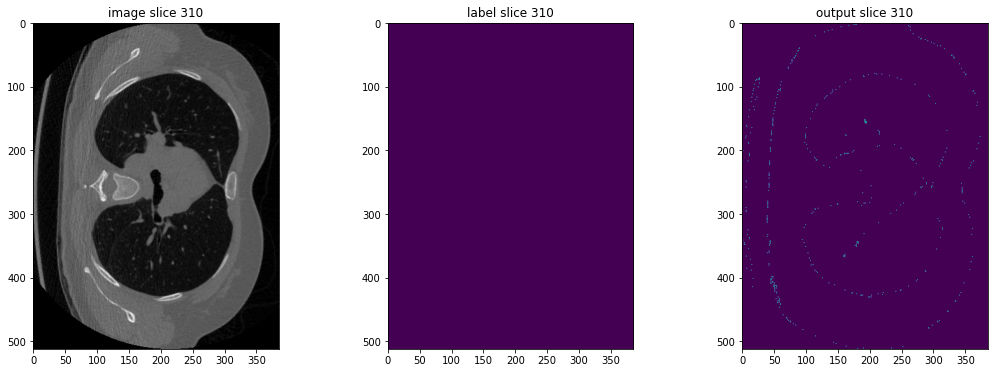

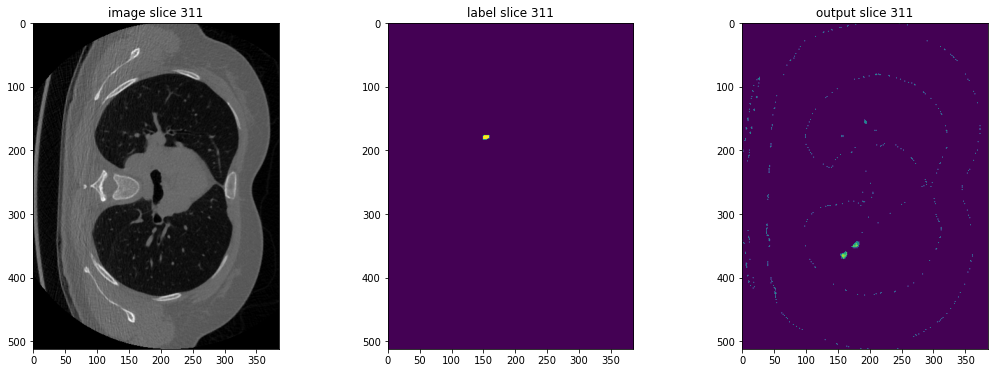

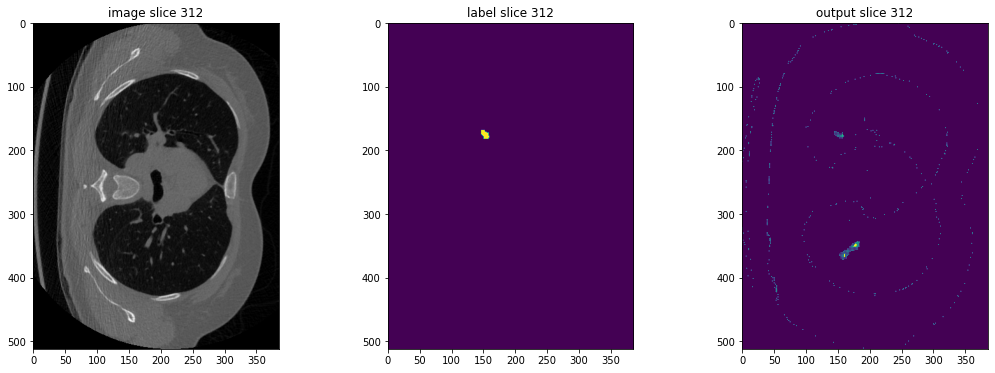

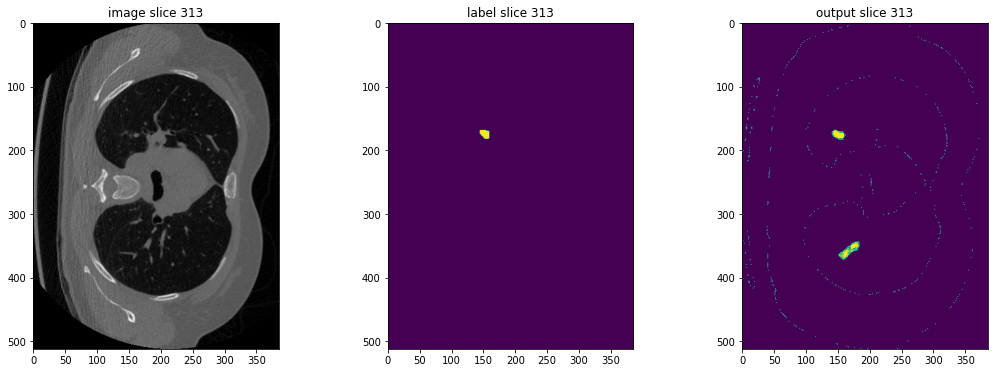

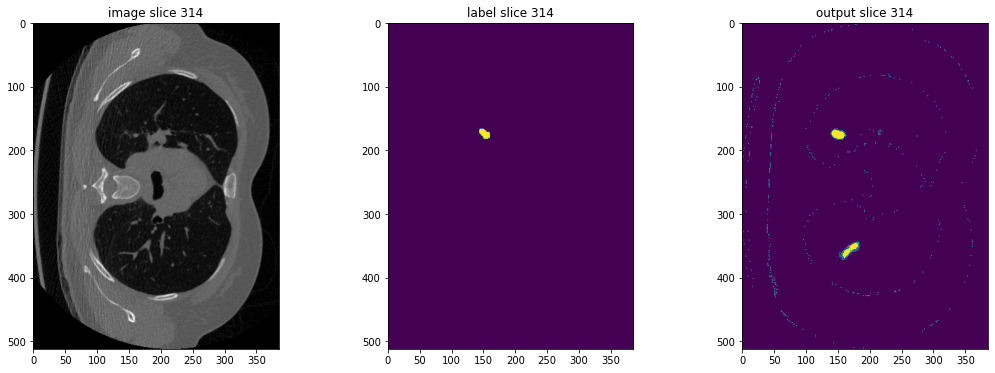

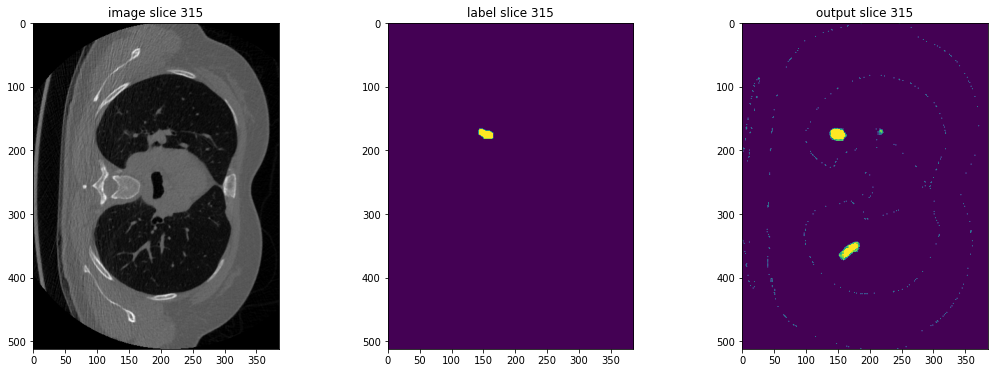

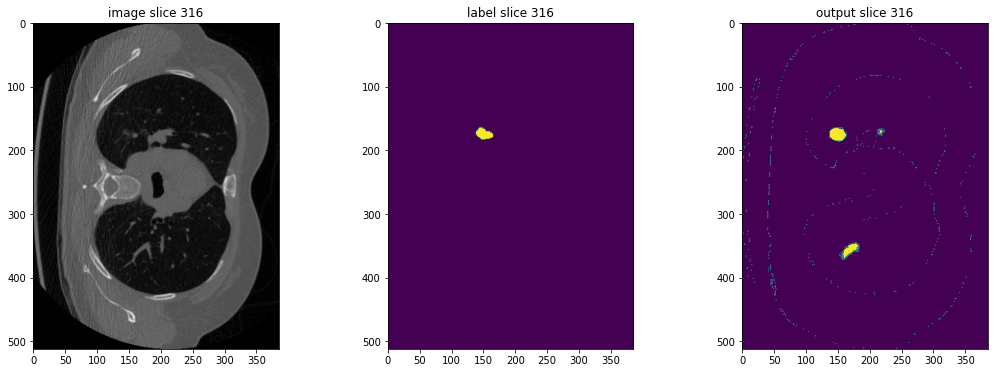

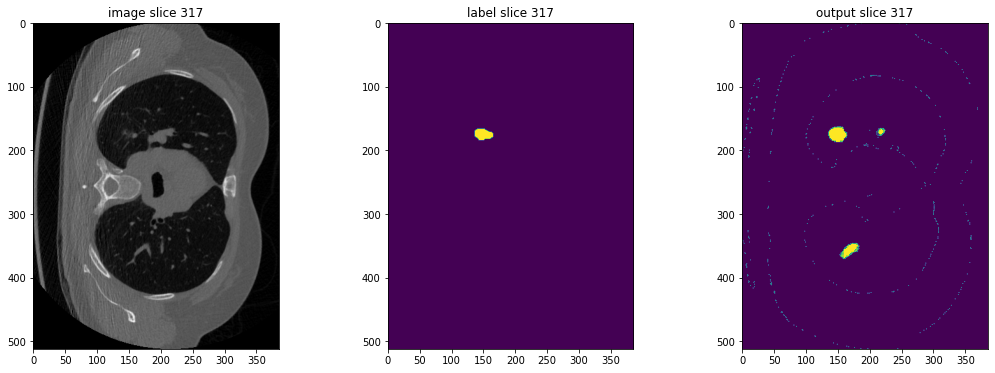

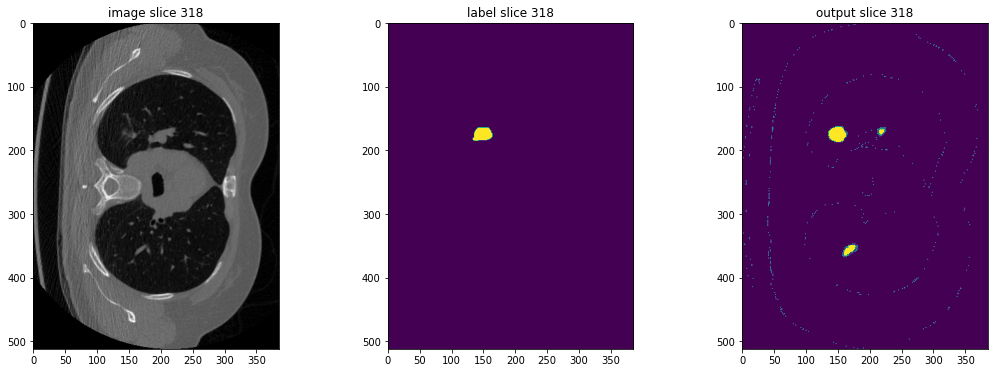

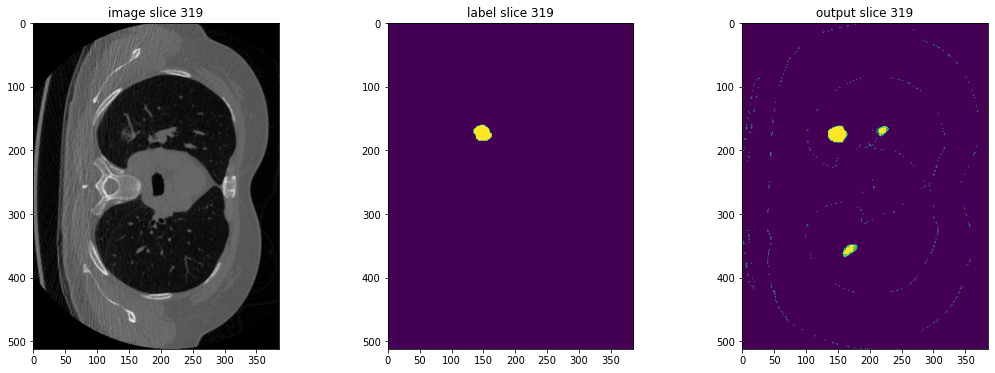

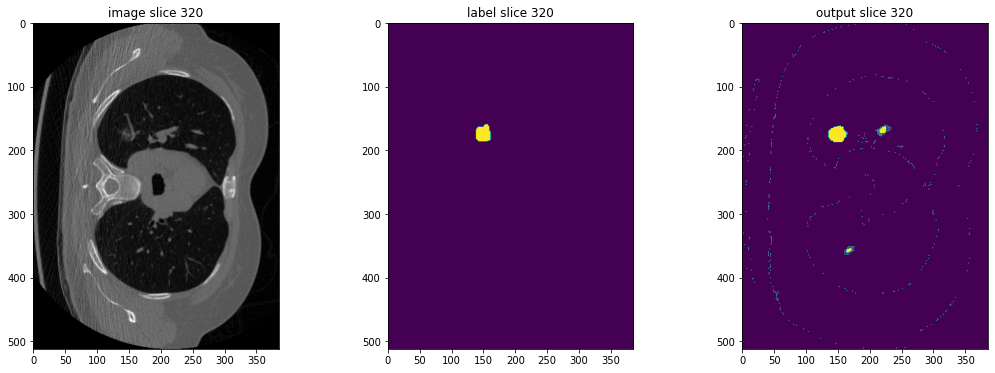

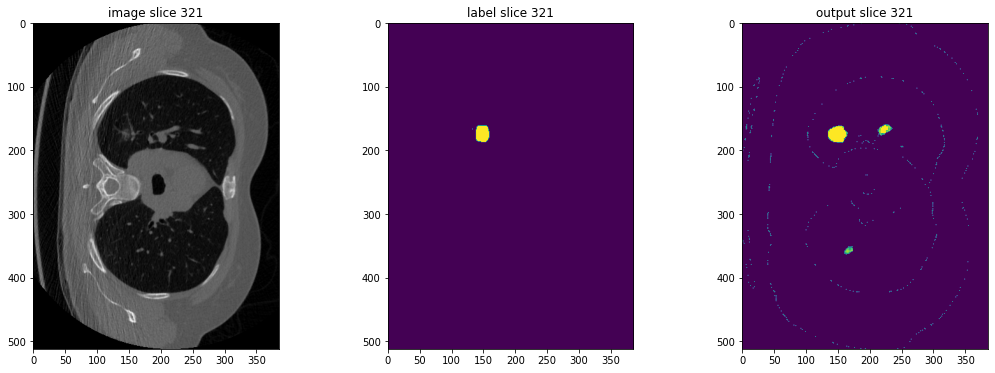

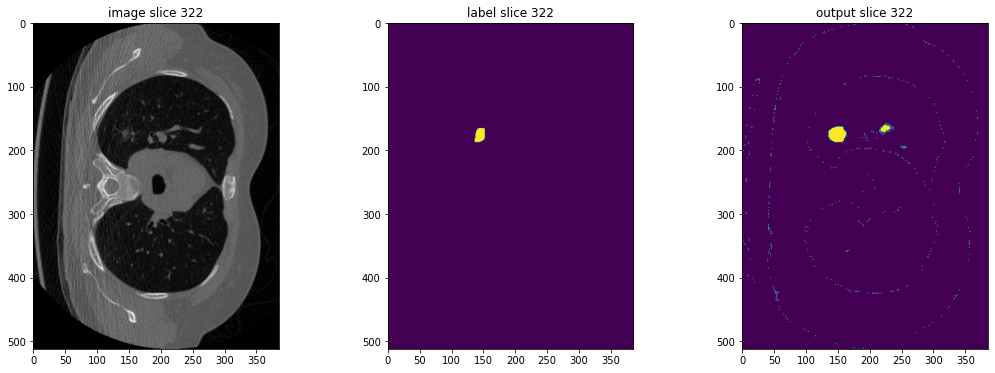

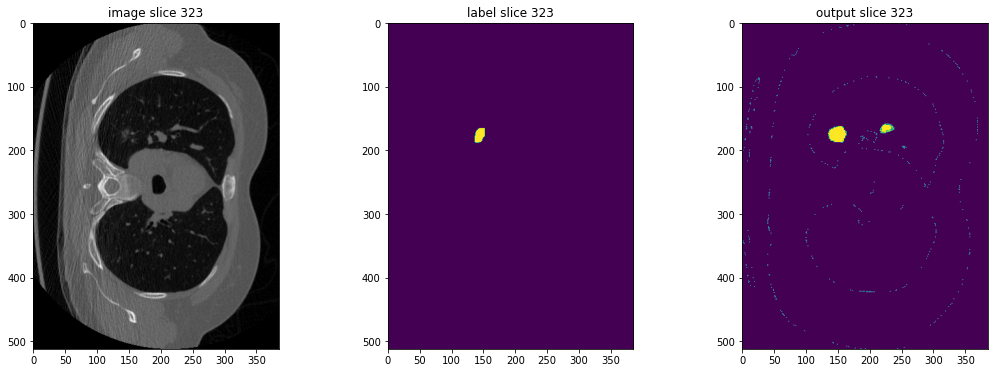

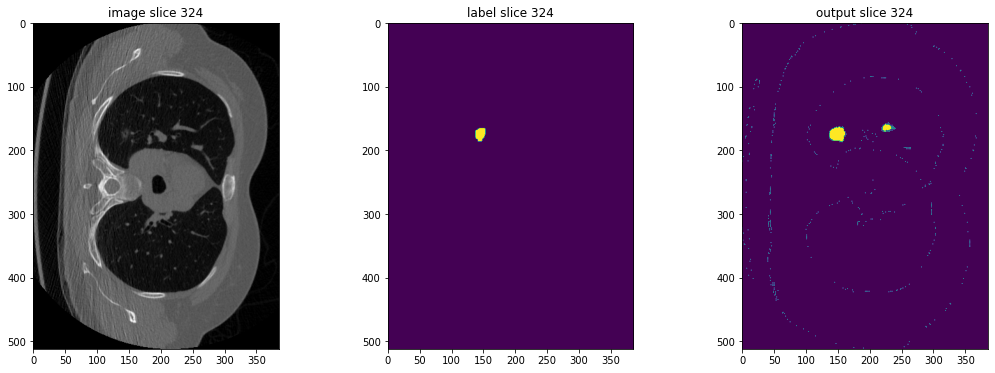

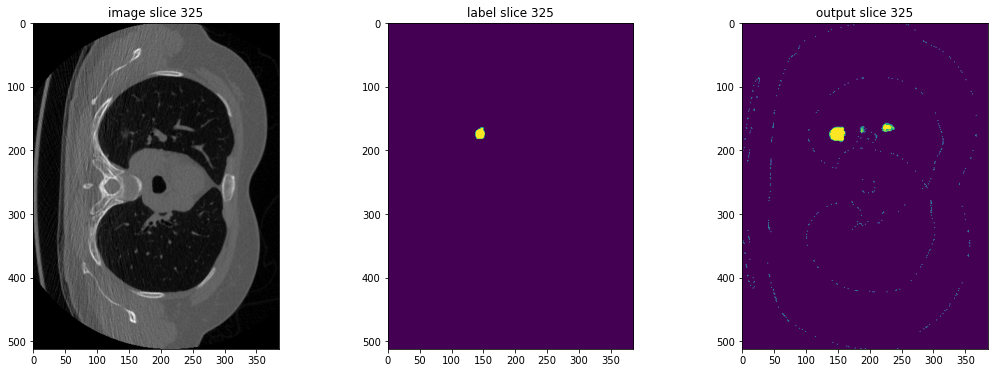

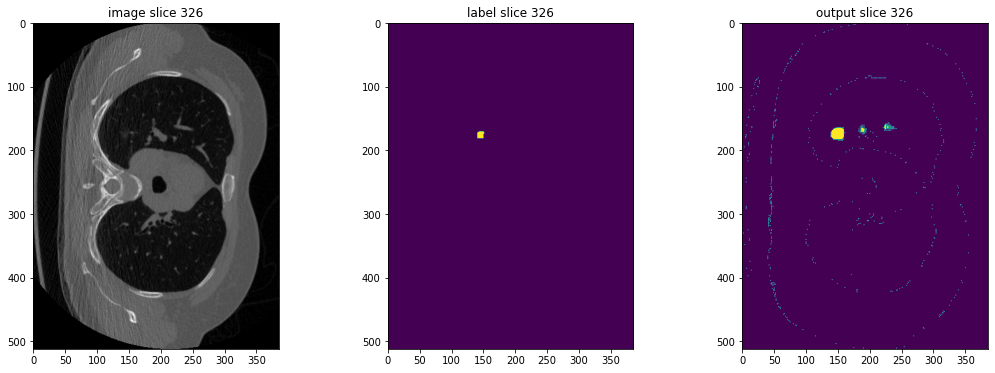

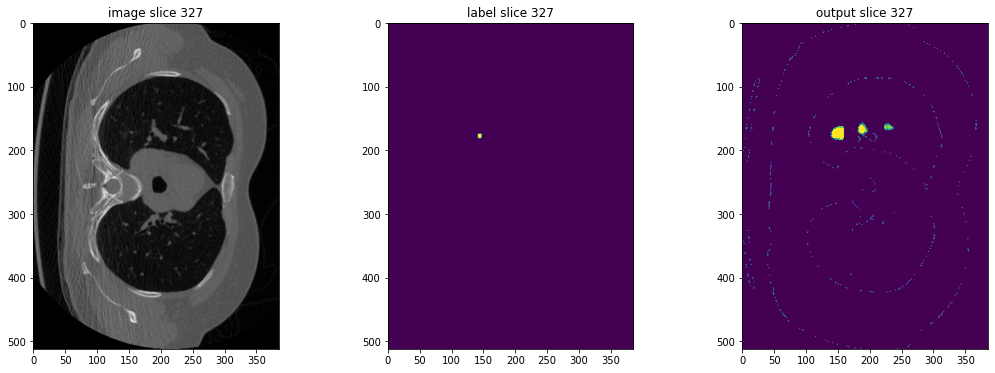

In [ ]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "MCNN_med_res.pth")))

model = model.to(device)
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model
        )
        # plot tumour slices (finding them first)
        for j in range(310,328):
          plt.figure("check", (18, 6))
          plt.subplot(1, 3, 1)
          plt.title(f"image slice {j}")
          plt.imshow(val_data["image"][0, 0, :, :, j], cmap="gray")
          plt.subplot(1, 3, 2)
          plt.title(f"label slice {j}")
          plt.imshow(val_data["label"][0, 0, :, :, j])
          plt.subplot(1, 3, 3)
          plt.title(f"output slice {j}")
          plt.imshow(torch.argmax(
              val_outputs[0], dim=1).detach().cpu()[0, :, :, j])
          plt.show()
        break